# Dataset

https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset?resource=download

# Imports

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Carga del dataset

In [55]:
data = pd.read_csv("Datasets/Exam_Score_Prediction.csv", sep=',')
data.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [56]:
gender_encoder = LabelEncoder()
gender_encoder.fit(data['gender'])
data['gender'] = gender_encoder.transform(data['gender'])
print("Gender codification")
print(list(gender_encoder.classes_))
print(gender_encoder.transform(gender_encoder.classes_))

course_encoder = LabelEncoder()
course_encoder.fit(data['course'])
data['course'] = course_encoder.transform(data['course'])
print("\nCourse codification")
print(list(course_encoder.classes_))
print(course_encoder.transform(course_encoder.classes_))

internet_access_encoder = LabelEncoder()
internet_access_encoder.fit(data['internet_access'])
data['internet_access'] = internet_access_encoder.transform(data['internet_access'])
print("\nCourse codification")
print(list(internet_access_encoder.classes_))
print(internet_access_encoder.transform(internet_access_encoder.classes_))

sleep_quality_encoder = LabelEncoder()
sleep_quality_encoder.fit(data['sleep_quality'])
data['sleep_quality'] = sleep_quality_encoder.transform(data['sleep_quality'])
print("\nSleep Quality codification")
print(list(sleep_quality_encoder.classes_))
print(sleep_quality_encoder.transform(sleep_quality_encoder.classes_))

study_method_encoder = LabelEncoder()
study_method_encoder.fit(data['study_method'])
data['study_method'] = study_method_encoder.transform(data['study_method'])
print("\nStudy Method codification")
print(list(study_method_encoder.classes_))
print(study_method_encoder.transform(study_method_encoder.classes_))

facility_rating_encoder = LabelEncoder()
facility_rating_encoder.fit(data['facility_rating'])
data['facility_rating'] = facility_rating_encoder.transform(data['facility_rating'])
print("\nFacility Rating codification")
print(list(facility_rating_encoder.classes_))
print(facility_rating_encoder.transform(facility_rating_encoder.classes_))

exam_difficulty_encoder = LabelEncoder()
exam_difficulty_encoder.fit(data['exam_difficulty'])
data['exam_difficulty'] = exam_difficulty_encoder.transform(data['exam_difficulty'])
print("\nExam Difficulty codification")
print(list(exam_difficulty_encoder.classes_))
print(exam_difficulty_encoder.transform(exam_difficulty_encoder.classes_))

Gender codification
['female', 'male', 'other']
[0 1 2]

Course codification
['b.com', 'b.sc', 'b.tech', 'ba', 'bba', 'bca', 'diploma']
[0 1 2 3 4 5 6]

Course codification
['no', 'yes']
[0 1]

Sleep Quality codification
['average', 'good', 'poor']
[0 1 2]

Study Method codification
['coaching', 'group study', 'mixed', 'online videos', 'self-study']
[0 1 2 3 4]

Facility Rating codification
['high', 'low', 'medium']
[0 1 2]

Exam Difficulty codification
['easy', 'hard', 'moderate']
[0 1 2]


In [24]:
data.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,1,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,2,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,1,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,2,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,0,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


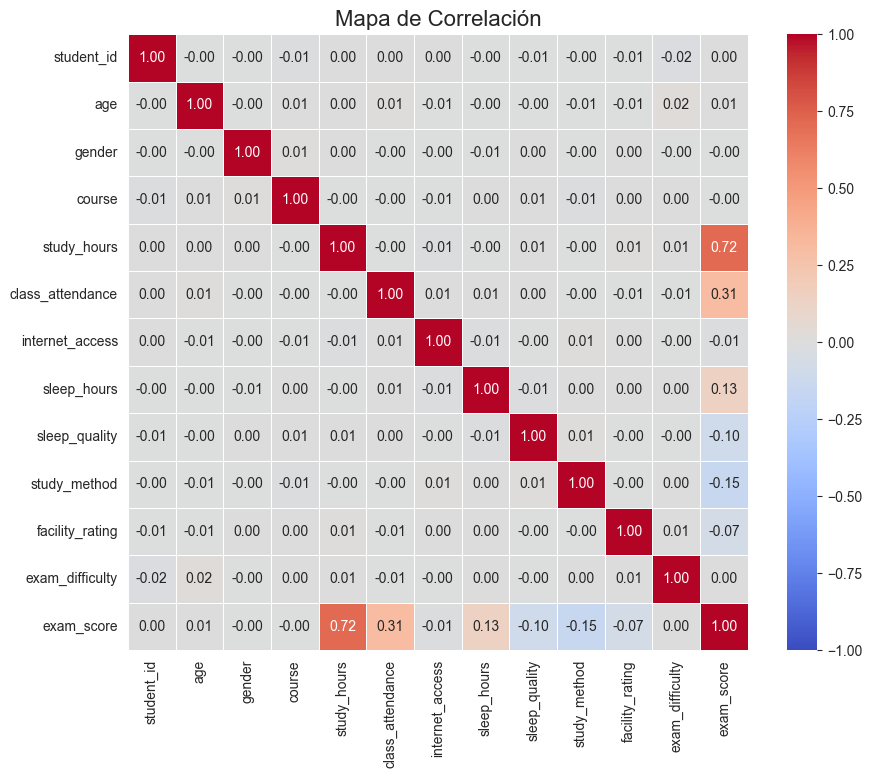

In [58]:
matriz_correlacion = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Mapa de Correlación', fontsize=16)
plt.show()

In [5]:
df = data.drop(columns=['student_id'])

# Mapeo manual para variables ordinales (que tienen orden lógico)
mappings = {
    'sleep_quality': {'poor': 0, 'average': 1, 'good': 2},
    'facility_rating': {'low': 0, 'medium': 1, 'high': 2},
    'exam_difficulty': {'easy': 0, 'moderate': 1, 'hard': 2},
    'internet_access': {'no': 0, 'yes': 1}
}

for col, mapping in mappings.items():
    df[col] = df[col].map(mapping)

# One-Hot Encoding para variables nominales (sin orden: genero, curso, metodo)
df = pd.get_dummies(df, columns=['gender', 'course', 'study_method'], drop_first=True)

# Separamos Features (X) y Target (y)
X = df.drop(columns=['exam_score'])
y_reg = df['exam_score']  # Objetivo para regresión (número continuo)
y_class = (df['exam_score'] >= 60).astype(int) # Objetivo para clasificación (0 o 1)

# Escalado de datos (importante para PCA y Redes Neuronales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dimensiones de los datos procesados: {X_scaled.shape}")
print("-" * 30)

# ---------------------------------------------------------
# 3. REGRESIÓN (Predecir la nota exacta)
# ---------------------------------------------------------
print("\n--- 1. REGRESIÓN LINEAL ---")
# Dividimos en train/test (usamos poco test porque hay pocos datos)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred_reg = reg_model.predict(X_test)

print(f"Predicciones (ejemplo): {y_pred_reg[:3]}")
print(f"Valores reales: {y_test.values[:3]}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, y_pred_reg):.2f}")

# ---------------------------------------------------------
# 4. CLASIFICACIÓN (Aprobado vs Reprobado)
# ---------------------------------------------------------
print("\n--- 2. CLASIFICACIÓN (Regresión Logística) ---")
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

clf_model = LogisticRegression()
clf_model.fit(X_train_c, y_train_c)
y_pred_class = clf_model.predict(X_test_c)

print(f"Precisión (Accuracy): {accuracy_score(y_test_c, y_pred_class):.2f}")
print("Matriz de Confusión:\n", confusion_matrix(y_test_c, y_pred_class))

# ---------------------------------------------------------
# 5. REDUCCIÓN DE DIMENSIONALIDAD (PCA)
# ---------------------------------------------------------
print("\n--- 3. REDUCCIÓN DE DIMENSIONALIDAD (PCA) ---")
pca = PCA(n_components=2) # Reducir a 2 columnas abstractas
X_pca = pca.fit_transform(X_scaled)

print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print("Primeras 3 filas transformadas a 2D:\n", X_pca[:3])

# ---------------------------------------------------------
# 6. AGRUPAMIENTO (K-Means Clustering)
# ---------------------------------------------------------
print("\n--- 4. CLUSTERING (K-Means) ---")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Añadimos el cluster al dataframe original para ver resultados
df_original_view = data
df_original_view['Cluster_Asignado'] = clusters
print("Ejemplo de agrupamiento (primeros 5 estudiantes):")
print(df_original_view[['student_id', 'exam_score', 'Cluster_Asignado']].head())

# ---------------------------------------------------------
# 7. RED NEURONAL (Deep Learning con Keras)
# ---------------------------------------------------------
print("\n--- 5. RED NEURONAL (Regresión) ---")

# Definir la arquitectura
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Capa oculta 1
    Dense(32, activation='relu'),                                  # Capa oculta 2
    Dense(1, activation='linear')                                  # Salida (1 valor continuo)
])

# Compilar
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar (usamos epochs bajas por ser demo)
history = model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=4)

# Evaluar
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida final (MSE) en test: {loss:.2f}")

# Predecir un ejemplo
pred_nn = model.predict(X_test[:1])
print(f"Predicción NN para el primer test: {pred_nn[0][0]:.2f}, Real: {y_test.values[0]}")

Dimensiones de los datos procesados: (20000, 20)
------------------------------

--- 1. REGRESIÓN LINEAL ---
Predicciones (ejemplo): [36.83664413 80.14308562 54.42191016]
Valores reales: [31.1 81.6 68. ]
Error Cuadrático Medio (MSE): 95.47

--- 2. CLASIFICACIÓN (Regresión Logística) ---
Precisión (Accuracy): 0.85
Matriz de Confusión:
 [[1500  312]
 [ 295 1893]]

--- 3. REDUCCIÓN DE DIMENSIONALIDAD (PCA) ---
Varianza explicada por cada componente: [0.07541132 0.06303303]
Primeras 3 filas transformadas a 2D:
 [[ 1.35571911  0.08285646]
 [-1.45377003  1.83156482]
 [ 1.61580242  0.21291569]]

--- 4. CLUSTERING (K-Means) ---
Ejemplo de agrupamiento (primeros 5 estudiantes):
   student_id  exam_score  Cluster_Asignado
0           1        58.9                 2
1           2        54.8                 1
2           3        90.3                 2
3           4        29.7                 1
4           5        43.7                 2

--- 5. RED NEURONAL (Regresión) ---


C:\Users\AVS\ETSII\Workspaces\MLE\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pérdida final (MSE) en test: 105.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Predicción NN para el primer test: 36.93, Real: 31.1
